### Intro to Random Forests
- #### Using **Fastai lib** approach:

In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [30]:
from fastai.imports import*
from fastai.tabular import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from IPython.display import display
from sklearn import metrics

In [34]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing,

## :Reading the files

In [17]:
%time df_raw = pd.read_csv(r'C:\Users\Girish Anna\data/Train.csv', low_memory=False, parse_dates=["saledate"])


Wall time: 40.9 s


## Display All Function:

In [18]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [19]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [20]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. 
# - Therefore we take the log of the prices, 
# - so that RMSE will give us what we need.

df_raw.SalePrice = np.log(df_raw.SalePrice)

- ##  Initial processing
    -This dataset contains a mix of **continuous and categorical variables**.

## constructing categories:
- **add_datepart()** method extracts date fields from complete datetime for the purpose of constructing categoricals

In [23]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

- The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest.
- Therefore we call ** train_cats** to **convert strings to pandas categories**.

## Train Categories method:

In [32]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [35]:
%time train_cats(df_raw)

Wall time: 3.2 s


In [37]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [40]:
# We can specify the order to use for categorical variables if we wish:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'],ordered=True, inplace=True) # with set_categories

- Pandas will treating them as numerical data internally
- But continue displaying them as text categories.
- Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [41]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [42]:
# we have lots of missing values,
# which we can't pass directly to a random forest.
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

### Save data to Feather format:

In [43]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

## Pre - processing:

In [44]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

- #### We replace categories with their numerica codes,
    - handle missing continuous values,
    - and split the dependent variable into a separate variable

In [48]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1
        
        

In [49]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [50]:
# Data is in format acceptable to the model: we can pass to a random forest!
m = RandomForestRegressor(n_jobs = -1)
%time m.fit(df,y)


Wall time: 24.3 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [51]:
# print the score of the model
m.score(df,y)

0.9831292184562541

### R2 or r2 and pronounced "R squared":
- The coefficient of determination: is the proportion of the variance in the dependent variable that is predictable from the independent variable(s)

In [52]:
# Using all our data can lead to overfitting. 
# A validation set helps diagnose this problem.

def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [53]:
n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [54]:
X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

## Random Forests:
###    - Base model: using training and validation sets

In [55]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [56]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 22.1 s
[0.09048774691248157, 0.2485232408727905, 0.9828874639727564, 0.8896983546462175]


### Speed up the process

In [58]:
def get_sample(df,n):
    
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [59]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [60]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 743 ms
[0.11178640773866362, 0.35440339293169687, 0.9722770132377865, 0.7756925407938338]


### Single tree:

In [61]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5224531527902538, 0.5803762650346065, 0.39444063402203533, 0.39845619221104067]


In [63]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

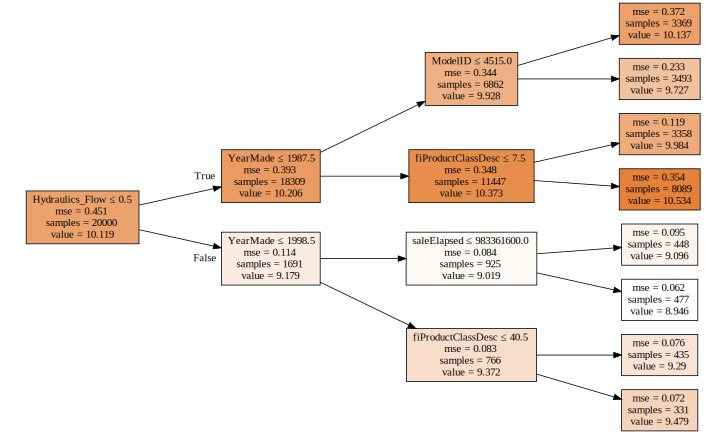

In [72]:
import graphviz
import IPython
from sklearn.tree import DecisionTreeClassifier, export_graphviz
draw_tree(m.estimators_[0], df_trn, precision=3)

In [69]:
### Setting up Environment Variable ::
# import os
# os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin\dot.exe'

In [73]:
#  we create a bigger tree.
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[5.756054031998178e-17, 0.47608733682382465, 1.0, 0.595217960620029]


## Bagging
-   **Intro to bagging**

In [74]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11291837153363568, 0.3560652718804138, 0.9717127173790916, 0.7735839500841142]


In [75]:
# grab the predictions for each individual tree, and look at one example.
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([8.935904, 9.510445, 9.615805, 8.935904, 9.10498 , 9.076809, 9.433484, 9.433484, 9.740969, 9.510445]),
 9.32982277667754,
 9.104979856318357)

In [76]:
preds.shape

(10, 12000)

In [82]:
# To Add Text to the Graph::
from pylab import figure, text, scatter, show

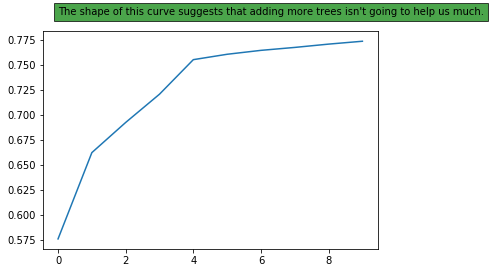

In [104]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);
#The shape of this curve suggests that adding more trees isn't going to help us much. Let's check.
# (Compare this to our original model on a sample)
plt_msg = "The shape of this curve suggests that adding more trees isn't going to help us much."

text(0,0.8,plt_msg, bbox=dict(facecolor='green', alpha=0.7));
# text(1,1,plt_msg, bbox=dict(facecolor='red', alpha=0.5))

In [105]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10252304014060777, 0.35883763289305065, 0.9766812659748315, 0.7700444264344074]


In [106]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1.97 s
[0.09713008904545002, 0.34618243266076165, 0.9790699825345861, 0.785978193817342]


In [107]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 6.54 s
[0.09393919819069896, 0.3429377474106591, 0.9804225684158062, 0.789971342823943]


### Out-of-bag (OOB) score:
- Is our validation set worse than our training set because we're **over-fitting,**
- or because the validation set is for a different time period, 
- or a bit of both? With the existing information we've shown, we can't tell. 

However, random forests have a very clever trick called **out-of-bag (OOB) error** which can handle this

**The idea is** to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. 
- This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our **model generalizes**, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

In [113]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)

print_score(m)
print("\nNote:: This shows that our validation set time difference is making an impact, as is model over-fitting.")

Wall time: 2.3 s
[0.09676166021942789, 0.3504460362947459, 0.9792284627117471, 0.7806739190076728, 0.8507288643836936]

Note:: This shows that our validation set time difference is making an impact, as is model over-fitting.


### Reducing over-fitting:
- #### Subsampling: 
    The easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: subsampling.



In [114]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

**The basic idea is** : rather than limit the total amount of data that our model can access, let's instead limit it to a different random subset per tree. That way, given enough trees, the model can still see all the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.
    

In [118]:
from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))


In [119]:
set_rf_samples(20000)

In [121]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

print("\nNote :: Since each additional tree allows the model to see more data, this approach can make additional trees more useful.")

Wall time: 4.32 s
[0.24029623100712422, 0.2790278520606299, 0.8793218221093329, 0.8609589349312899, 0.8667173460007399]

 Since each additional tree allows the model to see more data, this approach can make additional trees more useful.


In [122]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 12.8 s
[0.22687878915226667, 0.26384379628214694, 0.8924222101842086, 0.8756797862226235, 0.8809076296450504]


### Tree building parameters:
- We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [123]:
reset_rf_samples()

In [124]:
# full set to compare
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [125]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07835903126584788, 0.2355704568517914, 0.9871674506635348, 0.9008963562852951, 0.908596351391157]


In [126]:
t=m.estimators_[0].tree_

In [127]:
dectree_max_depth(t)

47

In [128]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.14075774021071202, 0.23320497636641743, 0.9585924630761316, 0.9028766617567879, 0.9068750997893088]


In [129]:
t=m.estimators_[0].tree_

In [130]:
dectree_max_depth(t)

36

- ### Another way to reduce over-fitting is to grow our trees less deeply.
- We do this by specifying (with min_samples_leaf) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [131]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11518279472960688, 0.23465842021254402, 0.9722725424113071, 0.9016622518516936, 0.9082788152210365]
